### Inverse Kinematics
```
Inverse kinematics finds the corresponding joint positions given target end-effector poses. 
```
- Inverse kinematics (IK) can be solved in two different ways: analytic and numerical
- In this tutorial, we focus on the numerical way of solving IK using a Jacobian matrix
WBWhiteBeard: 翻译这段话

GitHub Copilot: ### 逆运动学

逆运动学用于在给定目标末端执行器位姿的情况下，求解对应的关节位置。

- 逆运动学（IK）可以通过两种不同的方法求解：解析法和数值法
- 在本教程中，我们重点介绍如何利用雅可比矩阵，通过数值方法求解逆运动学

In [1]:
import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.4]


#### Parse `UR5e`

In [2]:
xml_path = '../asset/tabletop_manipulation/scene_ur5e_cylinders.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=True)

name:[Tabletop] dt:[0.002] HZ:[500]
n_qpos:[68] n_qvel:[60] n_qacc:[60] n_ctrl:[7]

n_body:[29]
 [0/29] [world] mass:[0.00]kg
 [1/29] [front_object_table] mass:[1.00]kg
 [2/29] [side_object_table] mass:[1.00]kg
 [3/29] [ur_base] mass:[4.00]kg
 [4/29] [ur_shoulder_link] mass:[3.70]kg
 [5/29] [ur_upper_arm_link] mass:[8.39]kg
 [6/29] [ur_forearm_link] mass:[2.27]kg
 [7/29] [ur_wrist_1_link] mass:[1.22]kg
 [8/29] [ur_wrist_2_link] mass:[1.22]kg
 [9/29] [ur_wrist_3_link] mass:[0.19]kg
 [10/29] [ur_tcp_link] mass:[0.00]kg
 [11/29] [ur_camera_mount] mass:[0.09]kg
 [12/29] [ur_d435i] mass:[0.07]kg
 [13/29] [ur_rg2_gripper_base_link] mass:[0.20]kg
 [14/29] [ur_camera_center] mass:[0.00]kg
 [15/29] [ur_rg2_gripper_finger1_finger_link] mass:[0.01]kg
 [16/29] [ur_rg2_gripper_finger1_inner_knuckle_link] mass:[0.01]kg
 [17/29] [ur_rg2_gripper_finger1_finger_tip_link] mass:[0.01]kg
 [18/29] [ur_rg2_gripper_finger2_finger_link] mass:[0.01]kg
 [19/29] [ur_rg2_gripper_finger2_inner_knuckle_link] mass:[

#### To solve IK
- compute the Jacobian matrix of the target body using `mujoco.mj_jacBody`
- compute the position and rotation error
- compute dq using least squares
- update

#### Dynamic Simulation using slider control with solving IK

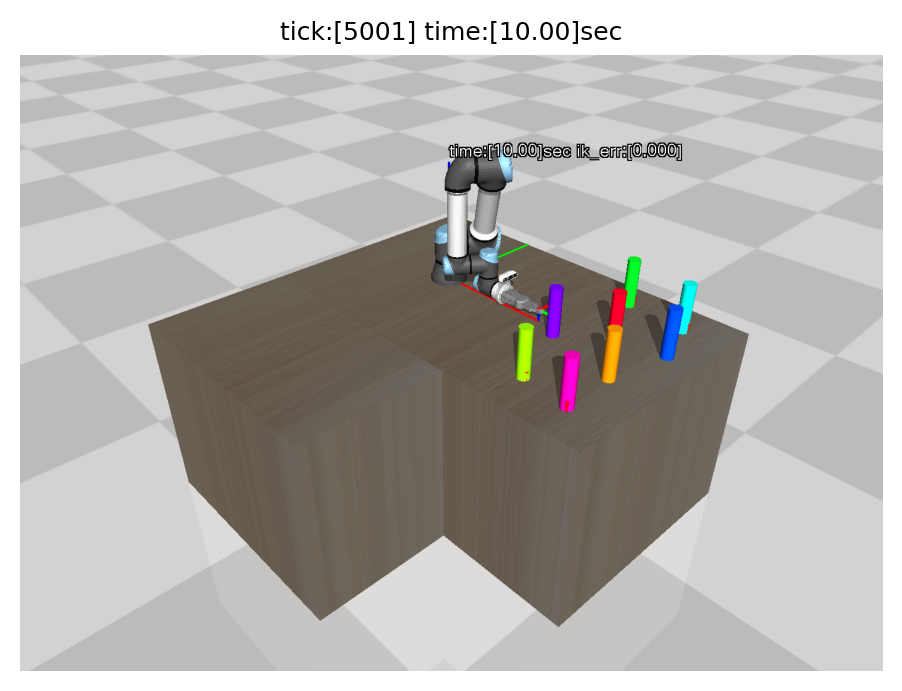

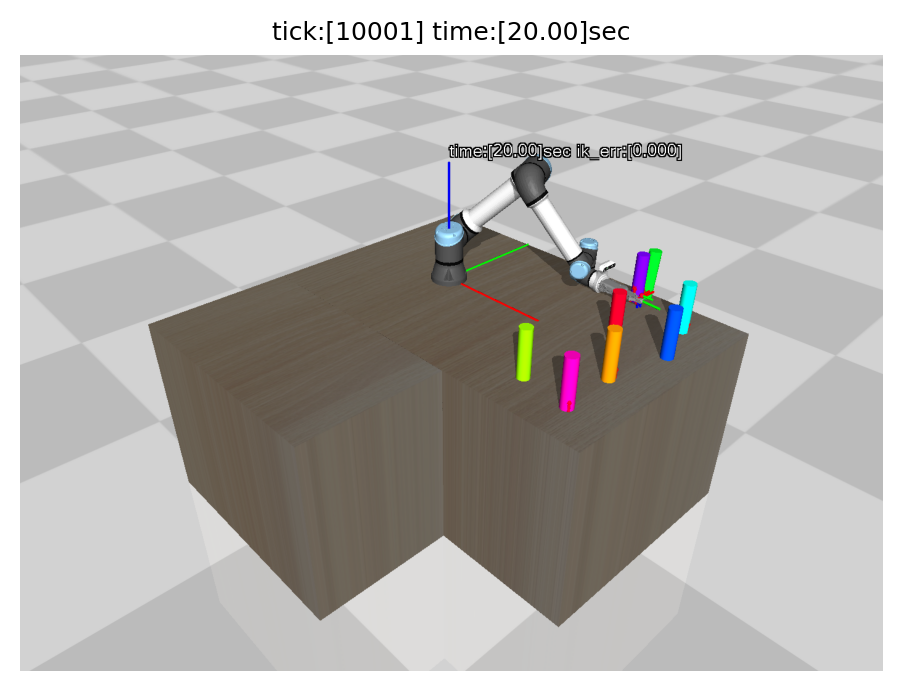

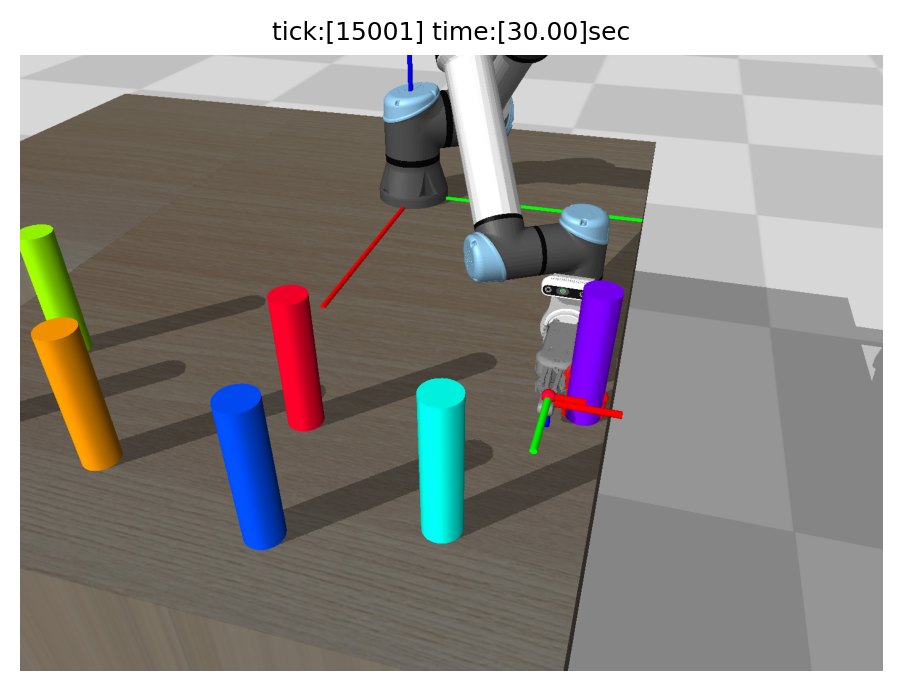

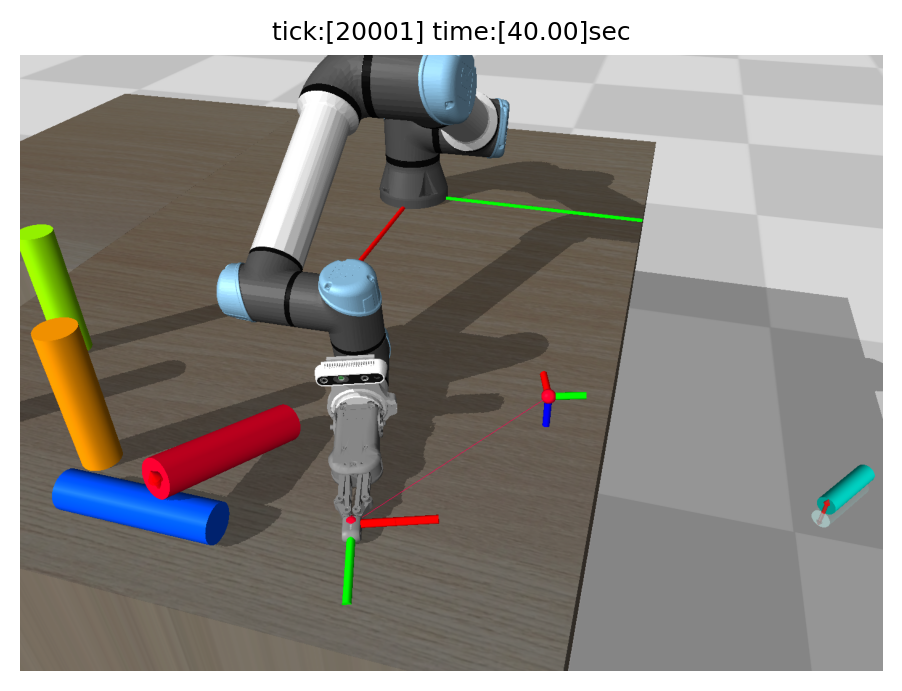

Done.


In [3]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,-1,-180,-180,-180,0],
    slider_maxs   = [+1,+1,+1,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)
joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
               'wrist_1_joint','wrist_2_joint','wrist_3_joint']
q0 = np.deg2rad([-35.63,-78.2,153.42,-75.22,54.37,-0.])
p0 = env.get_p_body(body_name='ur_base')+np.array([0.5,0.0,0.05])
R0 = rpy_deg2r([-180,0,90])
env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Move object positions
obj_names = env.get_body_names(prefix='obj_')
n_obj = len(obj_names)
obj_xyzs = sample_xyzs(
    n_sample  = n_obj,
    x_range   = [+0.6,+1.0],
    y_range   = [-0.45,+0.45],
    z_range   = [0.8,0.81],
    min_dist  = 0.2,
    xy_margin = 0.0
)
for obj_idx in range(n_obj):
    env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
    env.set_R_base_body(body_name=obj_names[obj_idx],R=np.eye(3,3))
env.set_geom_color(body_names_to_color=obj_names,rgba_list=get_colors(n_obj))
    
# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'ur_tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    env.step( # dynamic update
        ctrl        = np.append(qpos,xyzrpyg[6]),
        joint_names = joint_names+['gripper_finger2_joint'])

    # Click handler
    xyz_click,flag_click = env.get_xyz_left_double_click()
    if flag_click: print ("[CLICKED] p:%s"%(xyz_click))
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='ur_base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='ur_base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='ur_tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        if xyz_click is not None:
            env.plot_sphere(p=xyz_click,r=0.01,rgba=(1,0,0,0.5))
        env.render()
    if env.loop_every(tick_every=5000): 
        img = env.grab_image()
        plt.figure(figsize=(6,4)); plt.imshow(img); 
        plt.title('tick:[%d] time:[%.2f]sec'%
                  (env.tick,env.get_sim_time()),fontsize=9)
        plt.axis('off'); plt.show()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

#### Kinematic Simulation using slider control with solving IK

[CLICKED] p:[ 0.63998756 -0.120049    0.98045481]
[CLICKED] p:[ 0.65201057 -0.1194727   0.98713197]


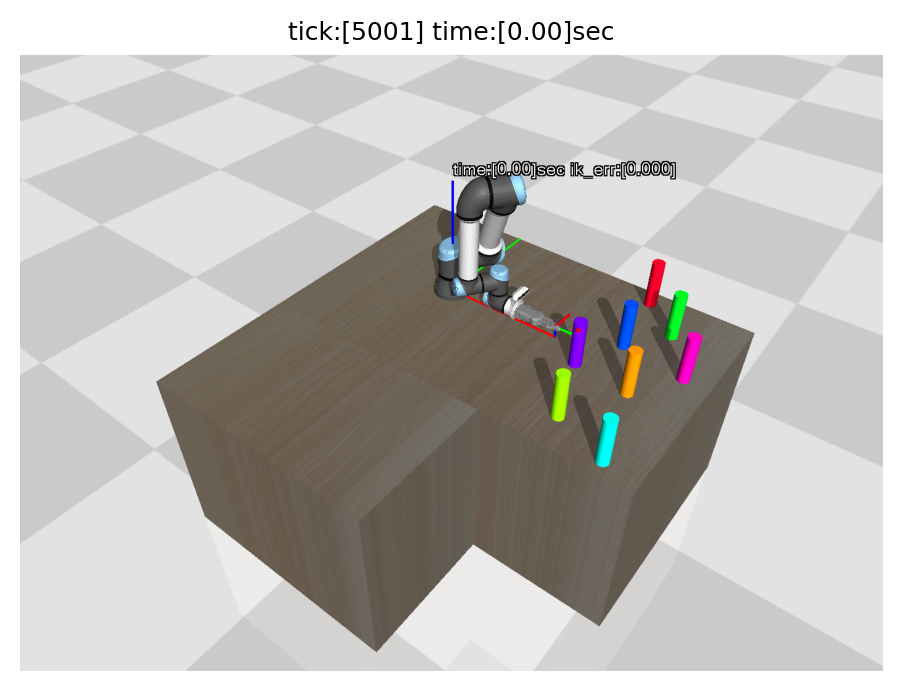

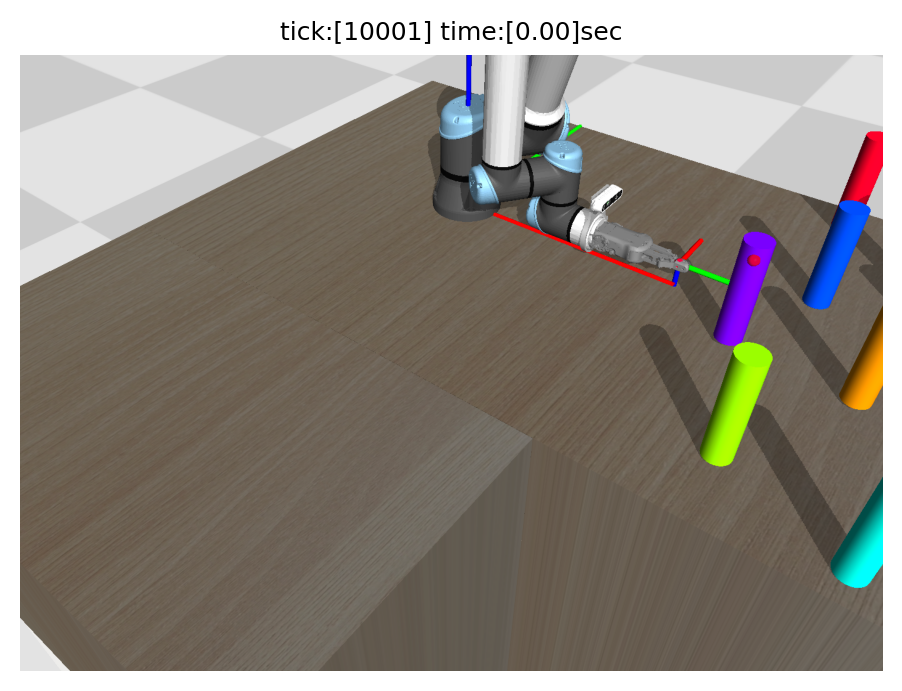

Done.


In [4]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,-1,-180,-180,-180,0],
    slider_maxs   = [+1,+1,+1,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)
joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
               'wrist_1_joint','wrist_2_joint','wrist_3_joint']
q0 = np.deg2rad([-35.63,-78.2,153.42,-75.22,54.37,-0.])
p0 = env.get_p_body(body_name='ur_base')+np.array([0.5,0.0,0.05])
R0 = rpy_deg2r([-180,0,90])
env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Move object positions
obj_names = env.get_body_names(prefix='obj_')
n_obj = len(obj_names)
obj_xyzs = sample_xyzs(
    n_sample  = n_obj,
    x_range   = [+0.6,+1.0],
    y_range   = [-0.45,+0.45],
    z_range   = [0.8,0.81],
    min_dist  = 0.2,
    xy_margin = 0.0
)
for obj_idx in range(n_obj):
    env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
    env.set_R_base_body(body_name=obj_names[obj_idx],R=np.eye(3,3))
env.set_geom_color(body_names_to_color=obj_names,rgba_list=get_colors(n_obj))
    
# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'ur_tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()    
    env.forward(q=qpos,joint_names=joint_names) # kinematic update

    # Click handler
    xyz_click,flag_click = env.get_xyz_left_double_click()
    if flag_click: print ("[CLICKED] p:%s"%(xyz_click))
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='ur_base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='ur_base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='ur_tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        if xyz_click is not None:
            env.plot_sphere(p=xyz_click,r=0.01,rgba=(1,0,0,0.5))
        env.render()
    if env.loop_every(tick_every=5000): 
        img = env.grab_image()
        plt.figure(figsize=(6,4)); plt.imshow(img); 
        plt.title('tick:[%d] time:[%.2f]sec'%
                  (env.tick,env.get_sim_time()),fontsize=9)
        plt.axis('off'); plt.show()

# Close
env.close_viewer()
sliders.close()
print ("Done.")